In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = self.nrow - 1

    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a, Q_max

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

In [3]:
import plotly.graph_objects as go
import plotly.offline as offline

def transfer_Qtable(myQtable, nrow, ncol):
  temp = np.empty((nrow, ncol), dtype=object)
  for i in range(myQtable.shape[0]):
    temp[nrow-1-int(i / ncol), int(i % ncol)] = myQtable[i, :]
  return temp

def myplot(mydots_x, mydots_y, myQtables, mydots_reward, nrow, ncol):
  scatter = go.Scatter(x=[0+0.5, ncol-0.5], y=[nrow-0.5, nrow-0.5], mode='markers', marker=dict(color='red'))
  layout = go.Layout(
      xaxis=dict(
          range=[0, ncol],
          tickvals=[i for i in range(0, ncol+1)],
          ticktext=['{}'.format(i) for i in range(0, ncol+1)]
      ),
      yaxis=dict(
          range=[0, nrow],
          tickvals=[i for i in range(0, nrow+1)],
          ticktext=['{}'.format(i) for i in range(0, nrow+1)]
      ),
      title='cliff walking',
      hovermode='closest',
      updatemenus=[dict(
          type="buttons",
          showactive=False,
          buttons=[dict(label="Play",
                method="animate",
                args=[None, {"frame": {"duration": 2000, "redraw": True},
                       'fromcurrent': True}]),
               dict(label='Pause',
                  method='animate',
                  args=[[None], {'frame': {'duration': 0, 'redraw': False},
                          'mode': 'immediate'}])])])
  mylabelss = []
  # print(myQtables)
  for k in range(len(myQtables)):
    # print('{}/{}'.format(k+1, len(myQtables)+1))
    mylabels = []
    # print(myQtables[k])
    transfered_Qtable = transfer_Qtable(myQtables[k], nrow, ncol)
    # print(transfered_Qtable)
    for i in range(transfered_Qtable.shape[0]):
      for j in range(transfered_Qtable.shape[1]):
        mylabel1 = go.layout.Annotation(
            y=nrow-(i+0.9),
            x=j+0.5,
            text='{:.4f}'.format(transfered_Qtable[i, j][0]),
            showarrow=False,
            font=dict(size=8)
        )
        mylabel2 = go.layout.Annotation(
            y=nrow-(i+0.2),
            x=j+0.5,
            text='{:.4f}'.format(transfered_Qtable[i, j][1]),
            showarrow=False,
            font=dict(size=8)
        )
        mylabel3 = go.layout.Annotation(
            y=nrow-(i+0.55),
            x=j+0.2,
            text='{:.4f}'.format(transfered_Qtable[i, j][2]),
            showarrow=False,
            font=dict(size=8)
        )
        mylabel4 = go.layout.Annotation(
            y=nrow-(i+0.55),
            x=j+0.8,
            text='{:.4f}'.format(transfered_Qtable[i, j][3]),
            showarrow=False,
            font=dict(size=8)
        )
        mylabels += [mylabel1, mylabel2, mylabel3, mylabel4]
    mylabelss.append(mylabels.copy())
  # print('length of mydots_x is {}'.format(len(mydots_x)))
  # print('length of mylabelss is {}'.format(len(mylabelss)))

  frames = []
  for i in range(len(mydots_y)):
    frame = go.Frame(
        layout=go.Layout(
            title_text=f"step {i}",
            annotations=mylabelss[i]
        ),
        data=[go.Scatter(
            x=[mydots_x[i]+0.5],
            y=[mydots_y[i]+0.5],
            text=[mydots_reward[i]],
            mode='markers+text',
            textposition='bottom center',
            marker=dict(color='blue'),
            name='markers'
        )]
    )
    frames.append(frame)

  # 我很奇怪，在点击了play后，go.Figure中的data参数的列表中的第一个scatter会被清除
  fig = go.Figure(data=[scatter,
              go.Scatter(x=[i+0.5 for i in range(1,ncol)], y=[nrow-0.5]*10, mode='markers', marker=dict(color='red', size=18)),
              go.Scatter(x=[0.5, ncol-0.5], y=[nrow-0.5]*2, text=['start', 'end'], mode="markers+text", textposition='bottom center')],
          frames=frames, layout=layout)
  fig.show()
  offline.plot(fig, filename='animated_plot.html', auto_open=False)

Iteration 9: 100%|██████████| 100/100 [00:00<00:00, 228.70it/s, episode=1000, return=-19.000]


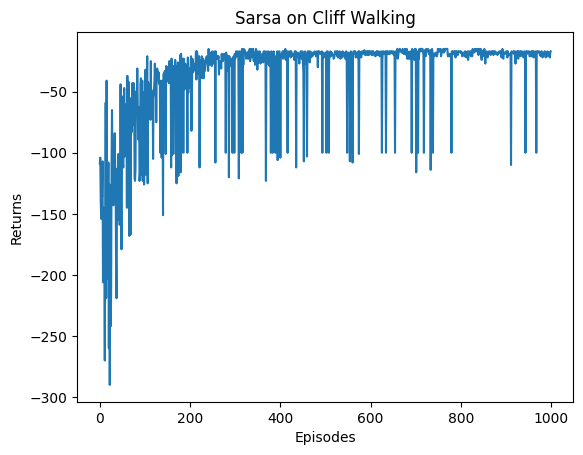

In [4]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
# np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 1000

return_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      mydots_x, mydots_y, mydots_reward = [], [], []
      myQtables = []
      episode_return = 0
      state = env.reset()
      action = agent.take_action(state)
      done = False
      while not done:
        mydots_x.append(env.x)
        mydots_y.append(env.y)
        myQtables.append(agent.Q_table.copy())
        # print(agent.Q_table)
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        _, return_ = agent.best_action(state)
        mydots_reward.append(round(return_, 4))
        episode_return += reward
        agent.update(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action
      if done:
        mydots_x.append(env.x)
        mydots_y.append(env.y)
        mydots_reward.append(' ')
        myQtables.append(agent.Q_table.copy())
      return_list.append(episode_return)
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
            'episode':
            '%d' % (num_episodes / 10 * i + i_episode + 1),
            'return':
            '%.3f' % np.mean(return_list[-10:])
        })
      pbar.update(1)
      # myplot(mydots_x, mydots_y, myQtables, mydots_reward)
      # break
  # myplot(mydots_x, mydots_y, myQtables, mydots_reward)
  # break
myplot(mydots_x, mydots_y, myQtables, mydots_reward, nrow, ncol)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

## Q-learning

In [ ]:
class QLearning:
  """ Q-learning算法 """
  def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
      self.Q_table = np.zeros([nrow * ncol, n_action])
      self.n_action = n_action
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon = epsilon

  def take_action(self, state):
    if np.random.random() < self.epsilon:
        action = np.random.randint(self.n_action)
    else:
        action = np.argmax(self.Q_table[state])
    return action

  def best_action(self, state):
    Q_max = np.max(self.Q_table[state])
    a = [0 for _ in range(self.n_action)]
    for i in range(self.n_action):
        if self.Q_table[state, i] == Q_max:
            a[i] = 1
    return a, Q_max

  def update(self, s0, a0, r, s1):
    td_error = r + self.gamma * self.Q_table[s1].max(
    ) - self.Q_table[s0, a0]
    self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 100/100 [00:00<00:00, 566.37it/s, episode=1000, return=-42.700]


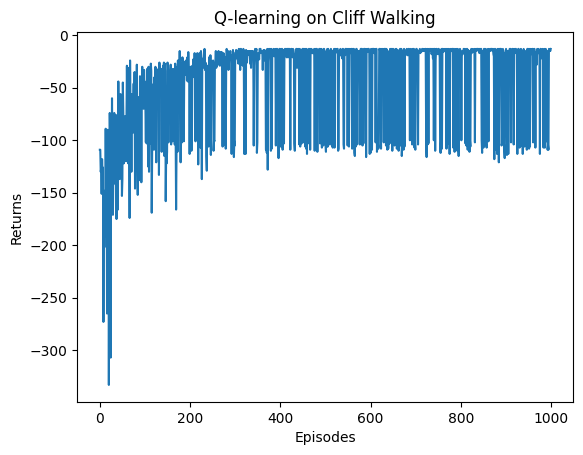

In [ ]:
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 1000

return_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      mydots_x, mydots_y, mydots_reward = [], [], []
      myQtables = []
      episode_return = 0
      state = env.reset()
      done = False
      while not done:
        mydots_x.append(env.x)
        mydots_y.append(env.y)
        myQtables.append(agent.Q_table.copy())
        action = agent.take_action(state)
        _, return_ = agent.best_action(state)
        mydots_reward.append(round(return_, 4))
        next_state, reward, done = env.step(action)
        episode_return += reward
        agent.update(state, action, reward, next_state)
        state = next_state
      if done:
        mydots_x.append(env.x)
        mydots_y.append(env.y)
        mydots_reward.append(' ')
        myQtables.append(agent.Q_table.copy())
        mydots_reward.append(' ')
      return_list.append(episode_return)
      if (i_episode + 1) % 10 == 0:
          pbar.set_postfix({
              'episode':
              '%d' % (num_episodes / 10 * i + i_episode + 1),
              'return':
              '%.3f' % np.mean(return_list[-10:])
          })
      pbar.update(1)
myplot(mydots_x, mydots_y, myQtables, mydots_reward, nrow, ncol)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

## DQN

In [ ]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
class ReplayBuffer:
  ''' 经验回放池 '''
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    transitions = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*transitions)
    return np.array(state), action, reward, np.array(next_state), done

  def size(self):
    return len(self.buffer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class Qnet(torch.nn.Module):
  ''' 只有一层隐藏层的Q网络 '''
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(Qnet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x)

In [ ]:
class DQN:
  ''' DQN算法 '''
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                epsilon, target_update, device):
    self.action_dim = action_dim
    self.q_net = Qnet(state_dim, hidden_dim,
                      self.action_dim).to(device)
    self.target_q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
    self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                      lr=learning_rate)
    self.gamma = gamma
    self.epsilon = epsilon
    self.target_update = target_update
    self.count = 0
    self.device = device

  def take_action(self, state):
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action

  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'],
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
        self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)

    q_values = self.q_net(states).gather(1, actions)
    max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
    q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
    self.optimizer.zero_grad()
    dqn_loss.backward()
    self.optimizer.step()

    if self.count % self.target_update == 0:
      self.target_q_net.load_state_dict(
          self.q_net.state_dict())
    self.count += 1

In [ ]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
framess = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      frames = []
      episode_return = 0
      state = env.reset()
      done = False
      while not done:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        episode_return += reward
        if replay_buffer.size() > minimal_size:
          b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
          transition_dict = {
              'states': b_s,
              'actions': b_a,
              'next_states': b_ns,
              'rewards': b_r,
              'dones': b_d
          }
          agent.update(transition_dict)
      return_list.append(episode_return)
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
            'episode':
            '%d' % (num_episodes / 10 * i + i_episode + 1),
            'return':
            '%.3f' % np.mean(return_list[-10:])
        })
      pbar.update(1)
      if i == 0 or i == 9:
        framess.append(frames.copy())
    # break

Iteration 9: 100%|██████████| 50/50 [00:58<00:00,  1.18s/it, episode=500, return=200.000]


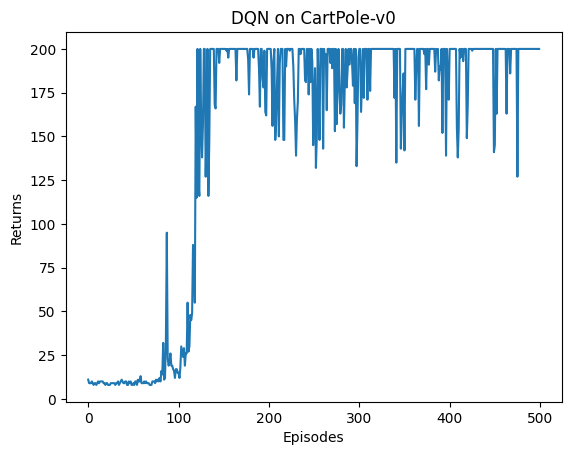

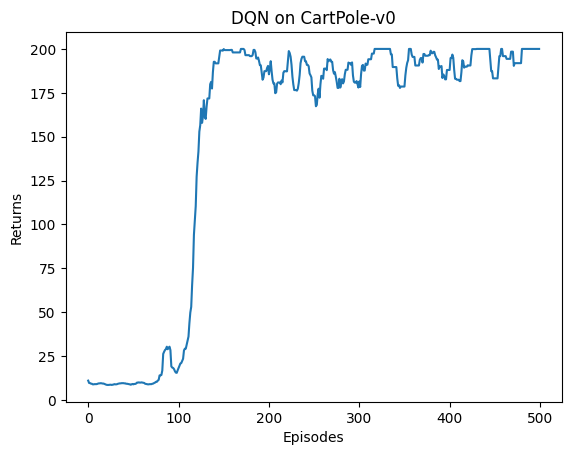

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

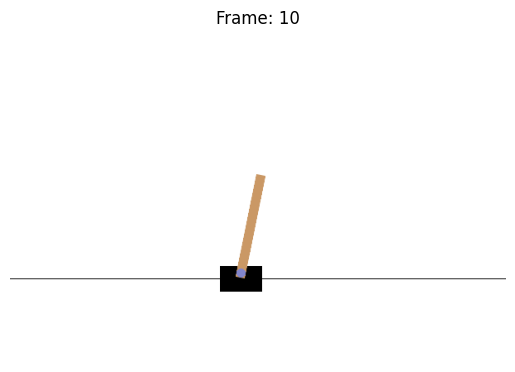

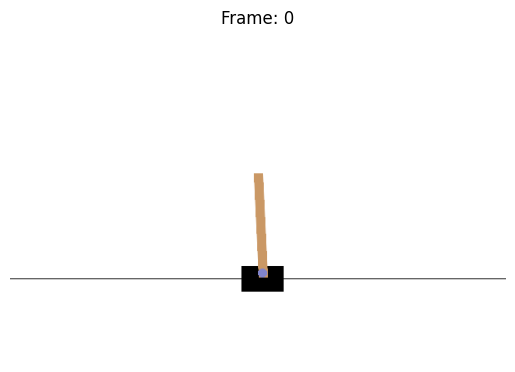

In [ ]:
myframe = framess[0]
fig = plt.figure()
patch = plt.imshow(myframe[0])
plt.axis('off')
def animate(i):
  patch.set_data(myframe[i])
  plt.title('Frame: {}'.format(i))
ani = animation.FuncAnimation(fig, animate, frames = len(myframe), interval = 50)
ani.save('dqn_cartpole_1.mp4')

myframe = framess[-1]
fig = plt.figure()
patch = plt.imshow(myframe[0])
plt.axis('off')
def animate(i):
  patch.set_data(myframe[i])
  plt.title('Frame: {}'.format(i))
ani = animation.FuncAnimation(fig, animate, frames = len(myframe), interval = 50)
ani.save('dqn_cartpole_2.mp4')